# Evaluation interface

Experimenting with code for evaluation

In [30]:
%reload_ext autoreload

%autoreload 2

import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

## Random sample

which is also a playground for creating a prediction set

In [3]:
test_path = os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets/2.2km-coarsened-8x_london_vorticity850_random/test.nc")
test_ds = xr.open_dataset(test_path)

In [4]:
samples = np.random.normal(size=(1, 2160, 64, 64))

In [5]:
coords = dict(test_ds.coords)#{key: dict(test_ds.coords)[key] for key in ["time", "grid_longitude", "grid_latitude"]}
coords = {**coords, "sample_id": ("sample_id", [1])}

pred_pr_dims=["sample_id", "time", "grid_latitude", "grid_longitude"]
pred_pr_attrs = {"grid_mapping": "rotated_latitude_longitude", "standard_name": "pred_pr", "units": "kg m-2 s-1"}
pred_pr_var = (pred_pr_dims, samples, pred_pr_attrs)
# data_vars = 

data_vars = {key: test_ds.data_vars[key] for key in ["rotated_latitude_longitude", "time_bnds", "grid_latitude_bnds", "grid_longitude_bnds", "forecast_period_bnds"]}
data_vars.update({"pred_pr": pred_pr_var})

sample_ds = xr.Dataset(data_vars=data_vars, coords=coords, attrs={})
sample_ds.to_netcdf("sample.nc")

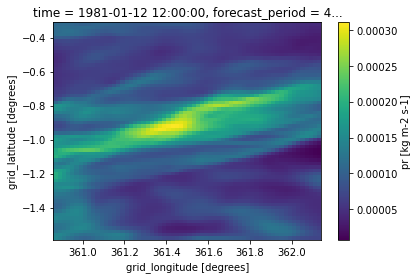

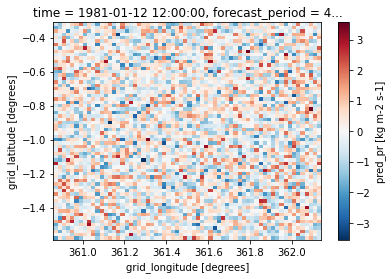

In [6]:
merged_ds = xr.merge([sample_ds, test_ds])

merged_ds.isel(sample_id=0, time=0)["target_pr"].plot()
plt.show()
merged_ds.isel(sample_id=0, time=0)["pred_pr"].plot()
plt.show()

## Generated predictions

In [7]:
pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous/2.2km-coarsened-8x_london_vorticity850_random/samples/checkpoint-18/val/predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets/2.2km-coarsened-8x_london_vorticity850_random/val.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))

pred_ds = pred_ds.isel(time=slice(1000))
eval_ds = eval_ds.isel(time=slice(1000))

merged_ds = xr.merge([pred_ds, eval_ds])

### Samples

In [55]:
merged_ds["target_pr"].isel(time=0, grid_latitude=2, grid_longitude=3).values

array(2.0412766e-10, dtype=float32)

In [60]:
merged_ds["target_pr"].values[0,2,3]

2.0412766e-10

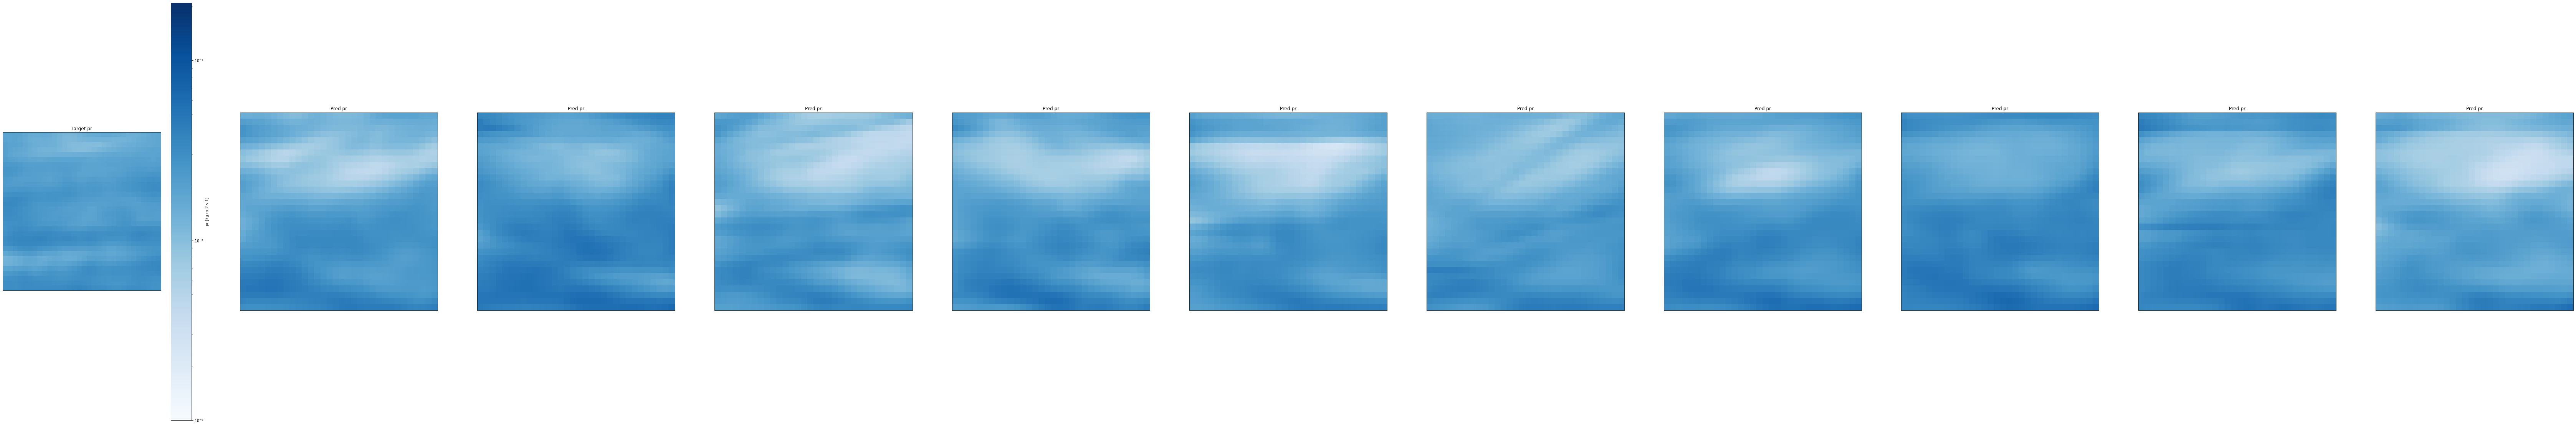

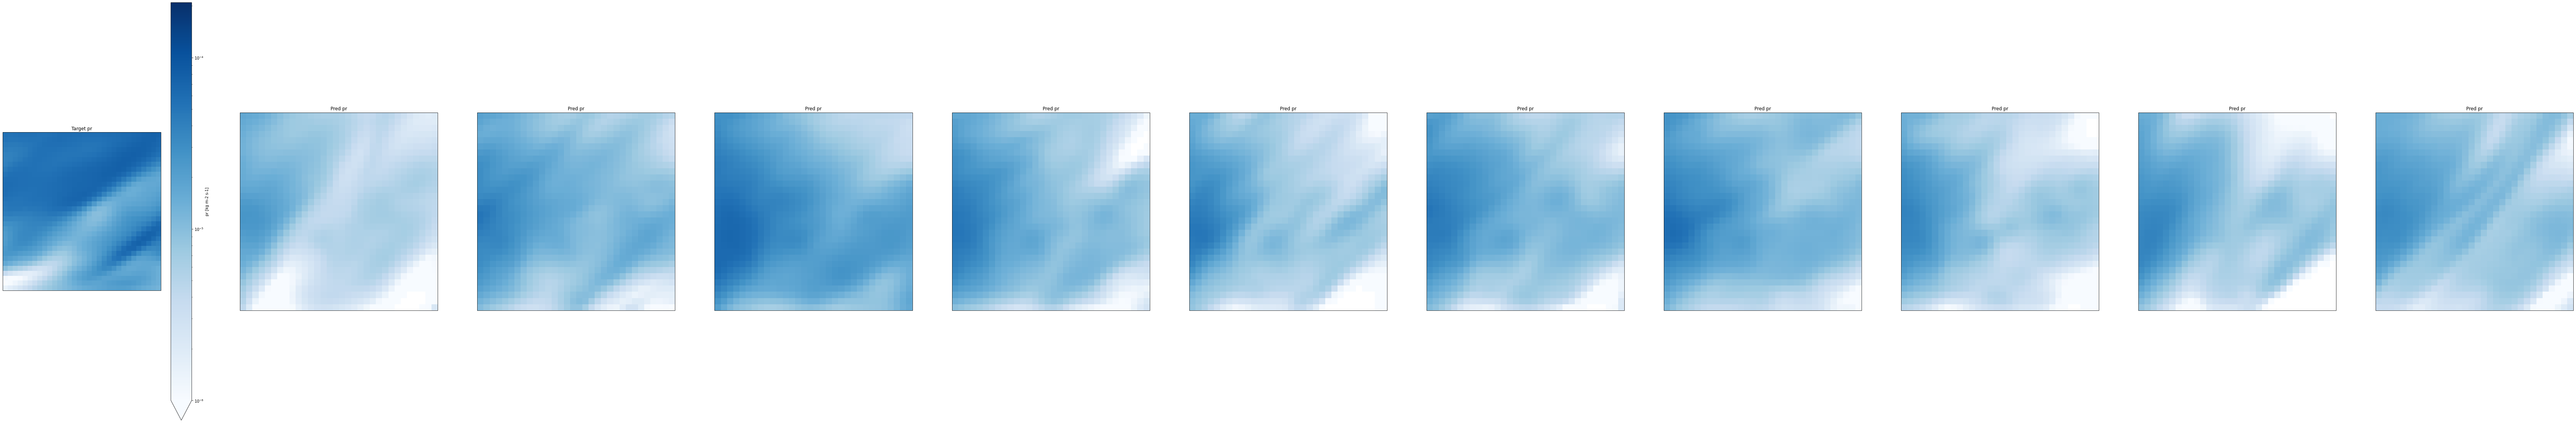

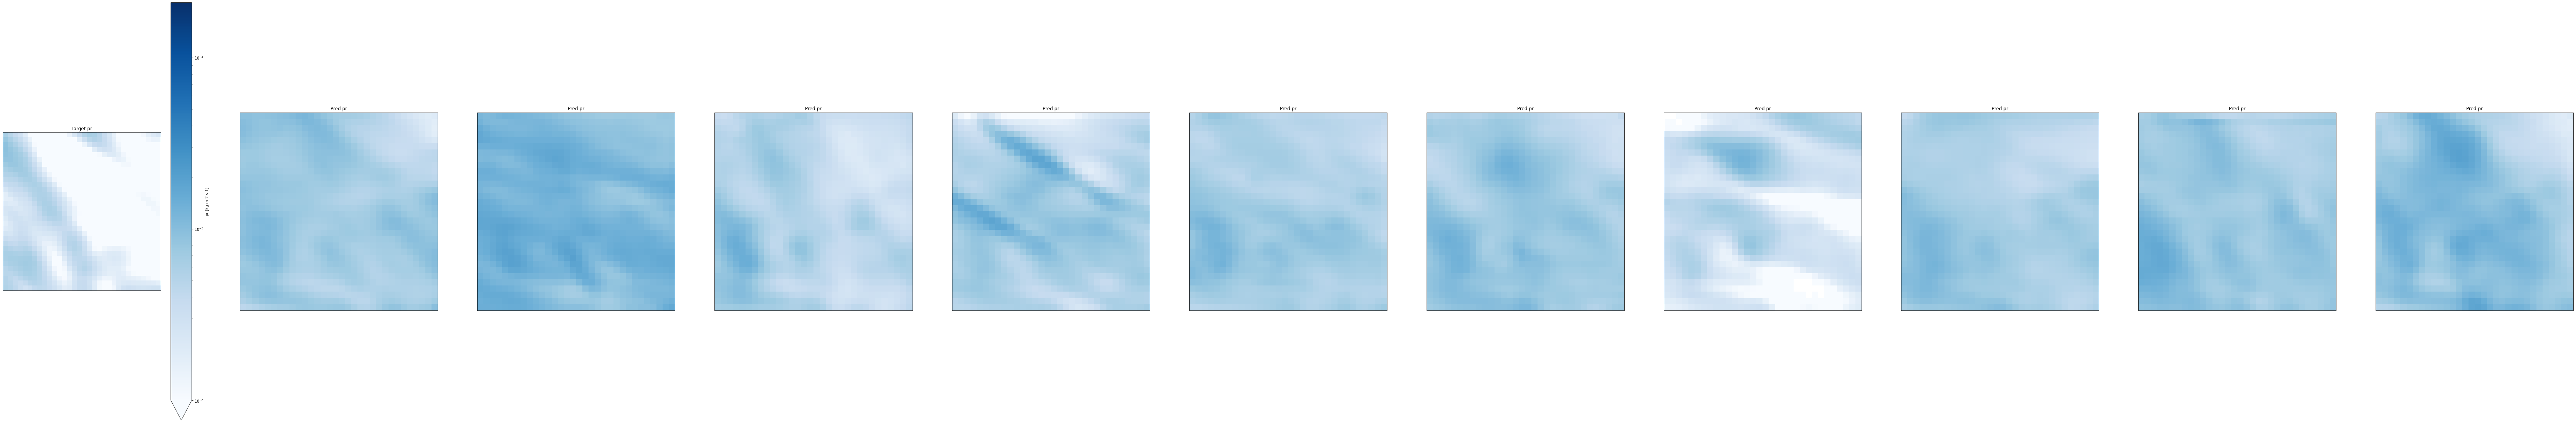

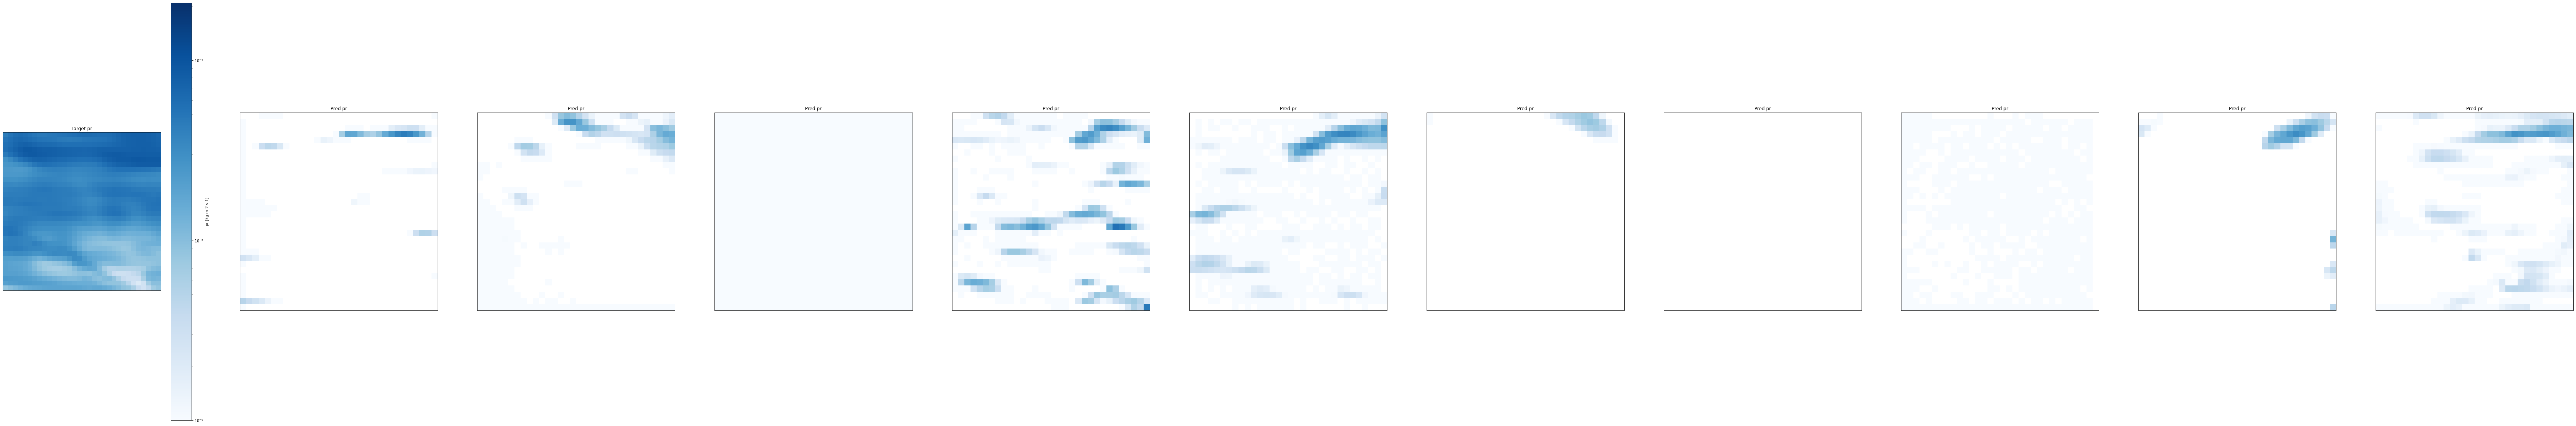

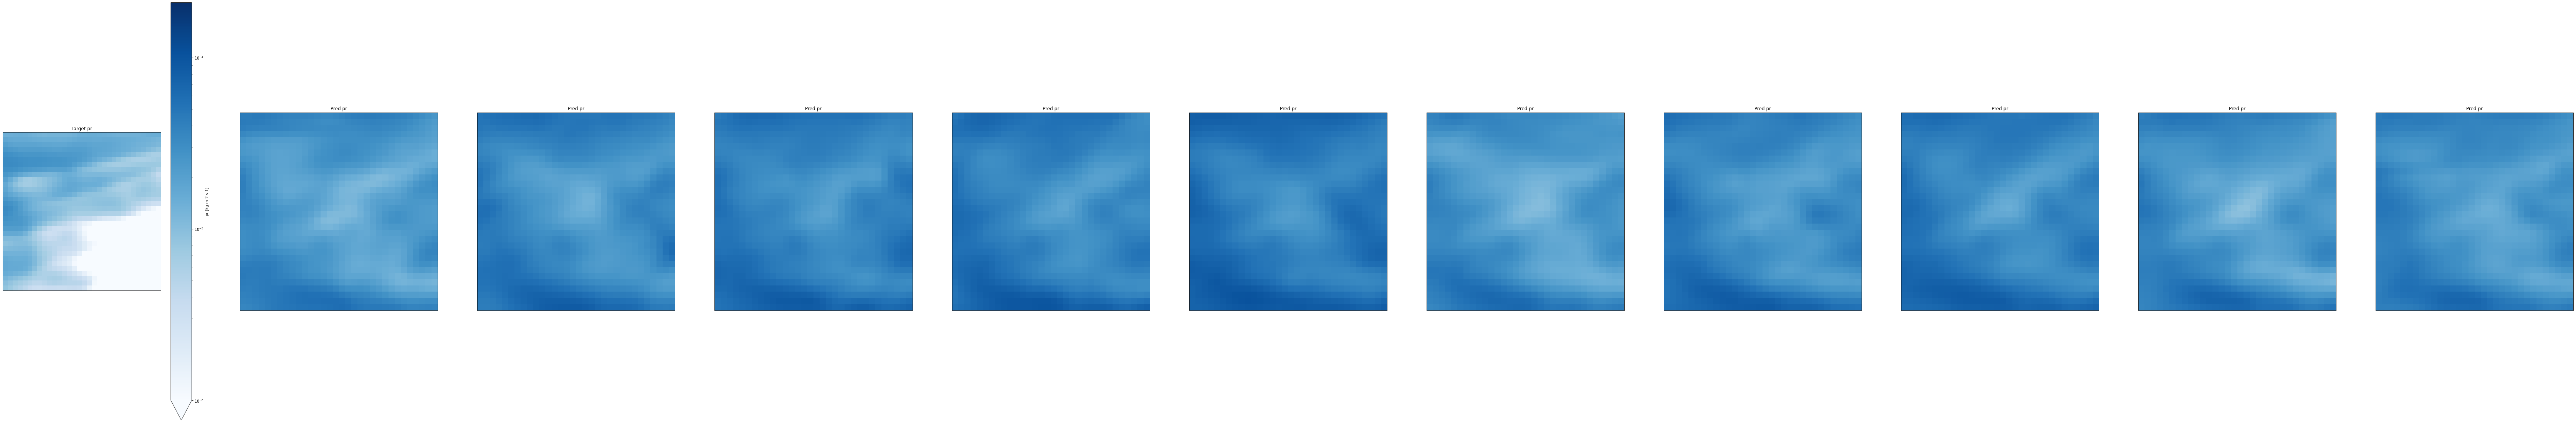

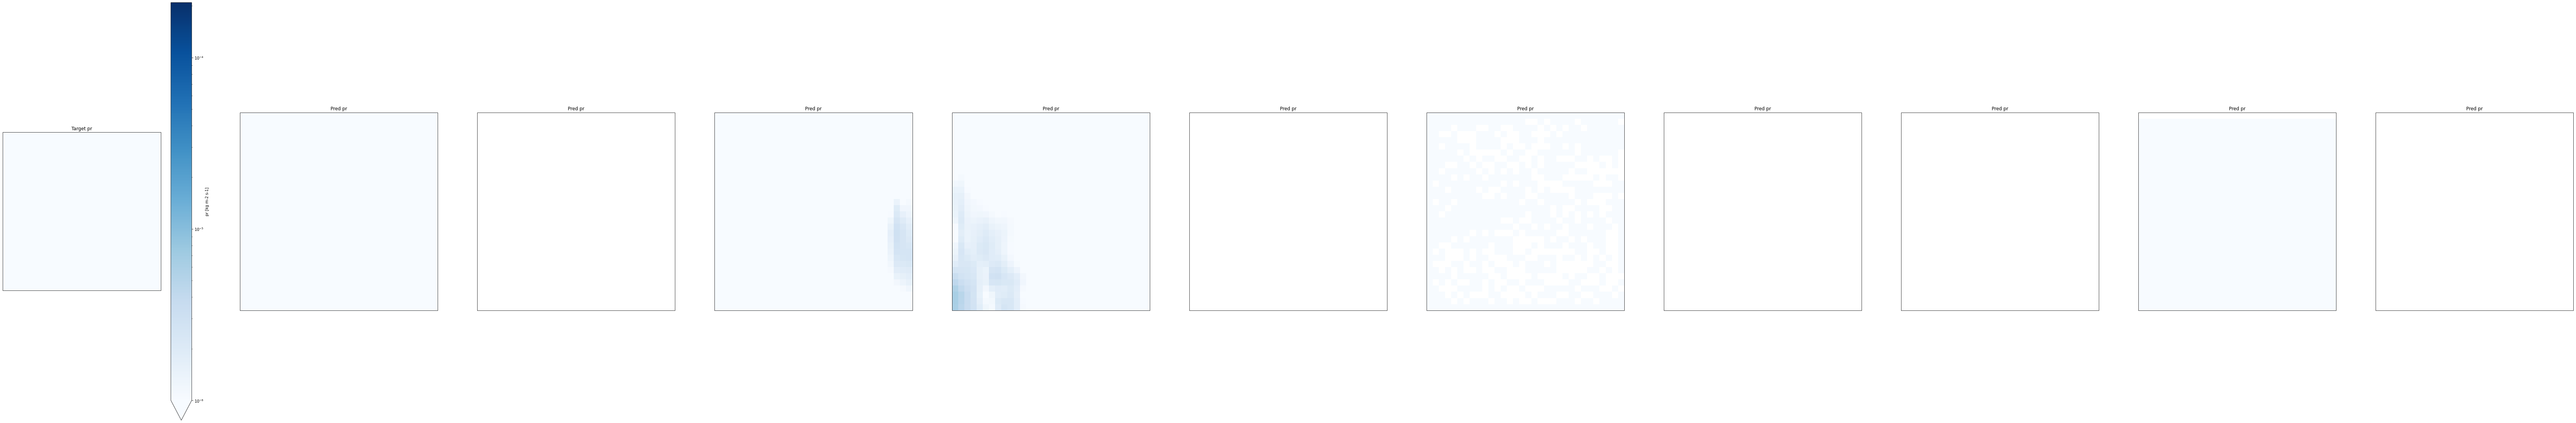

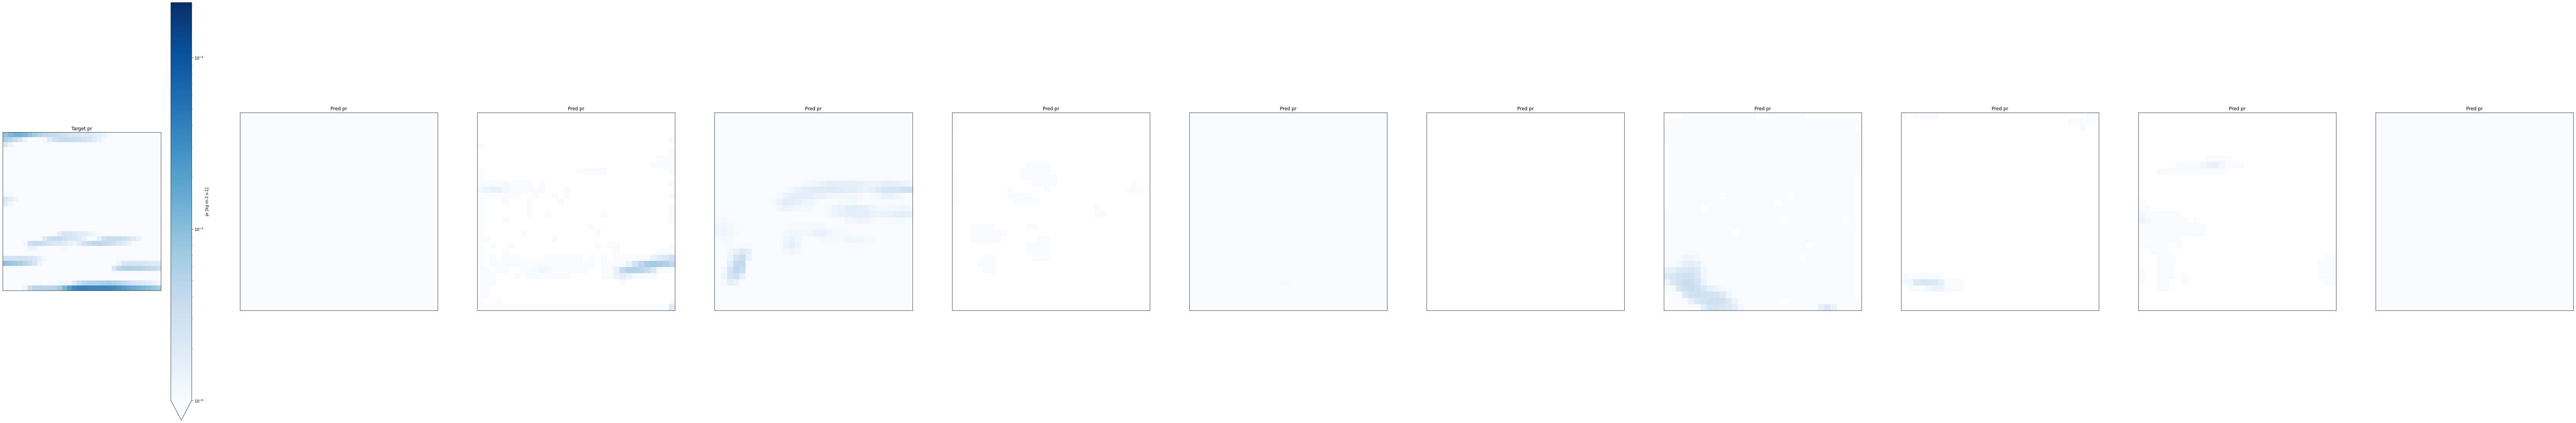

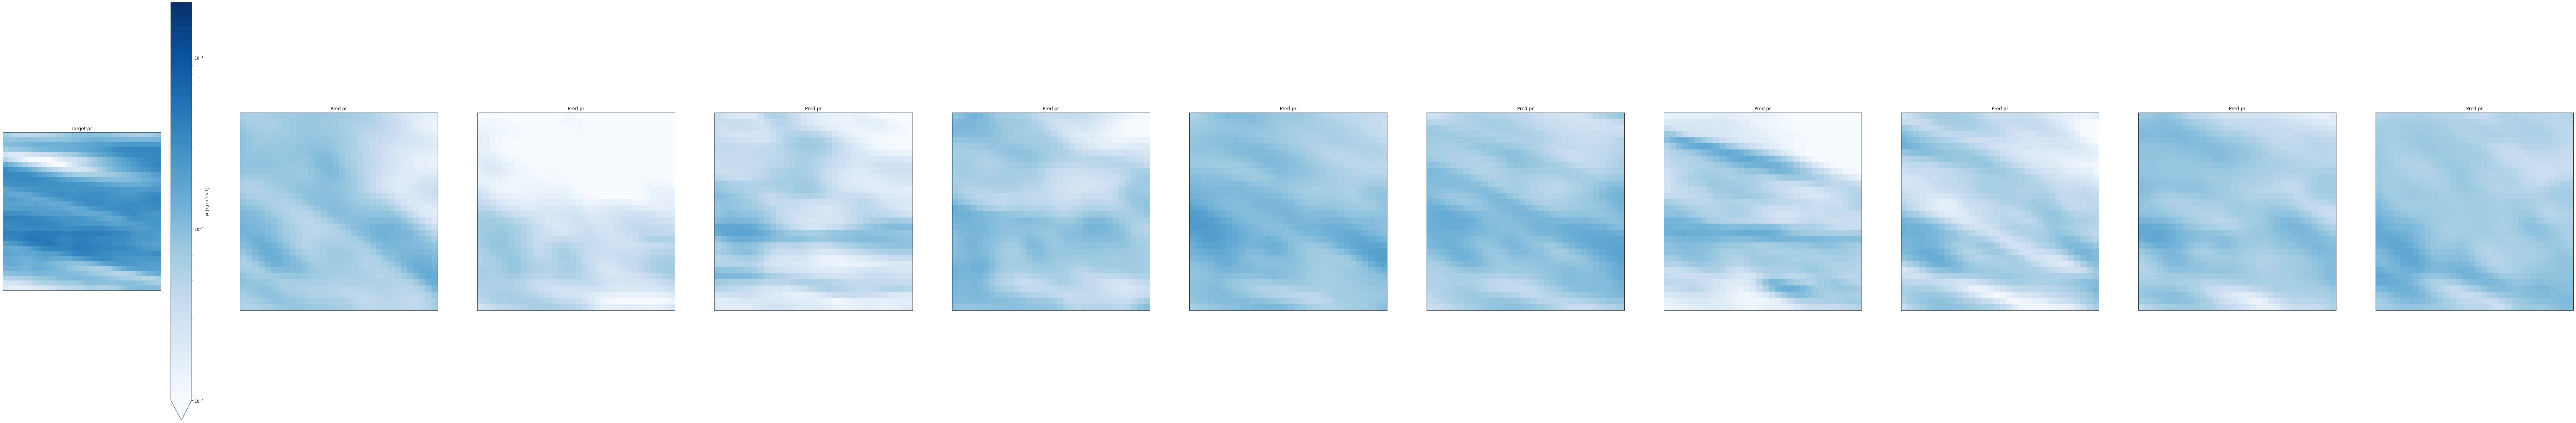

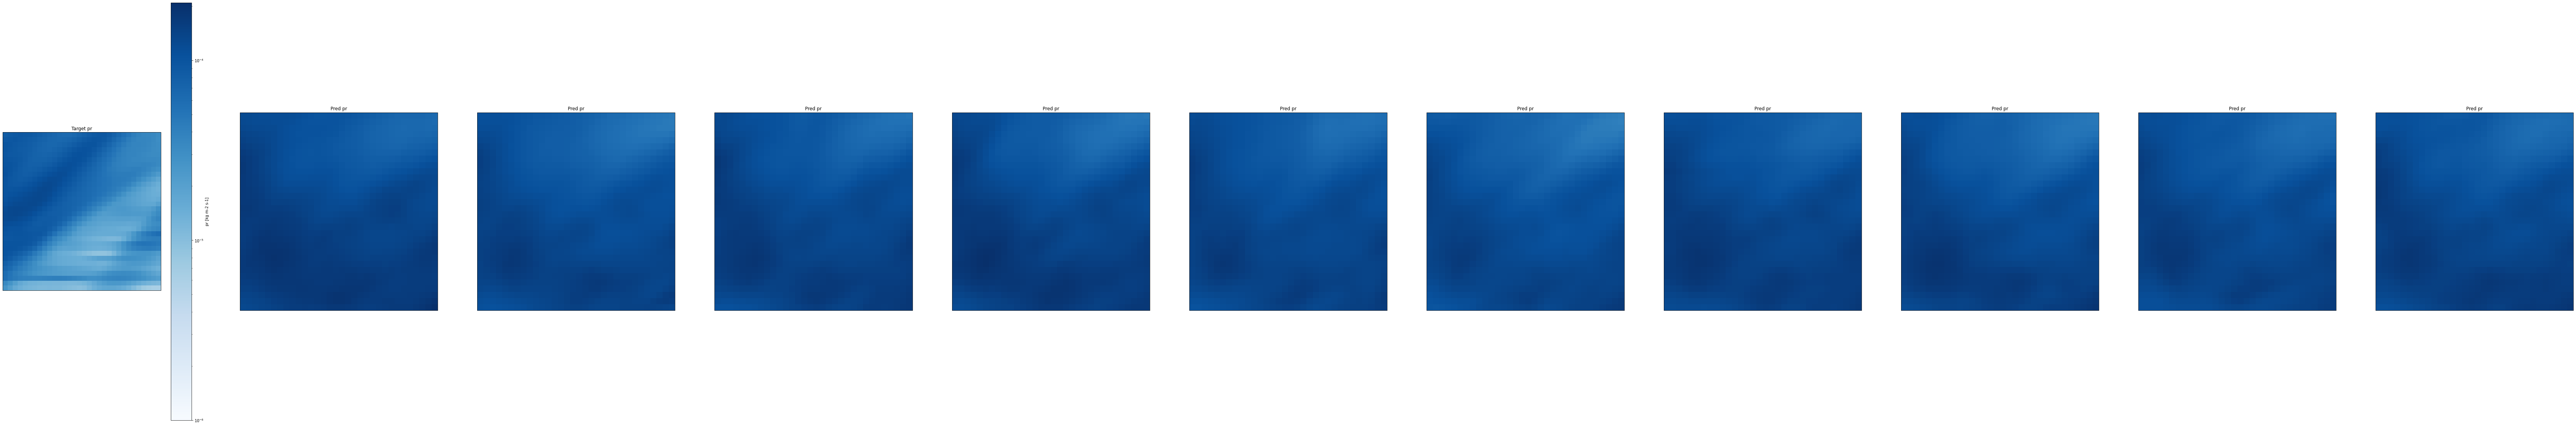

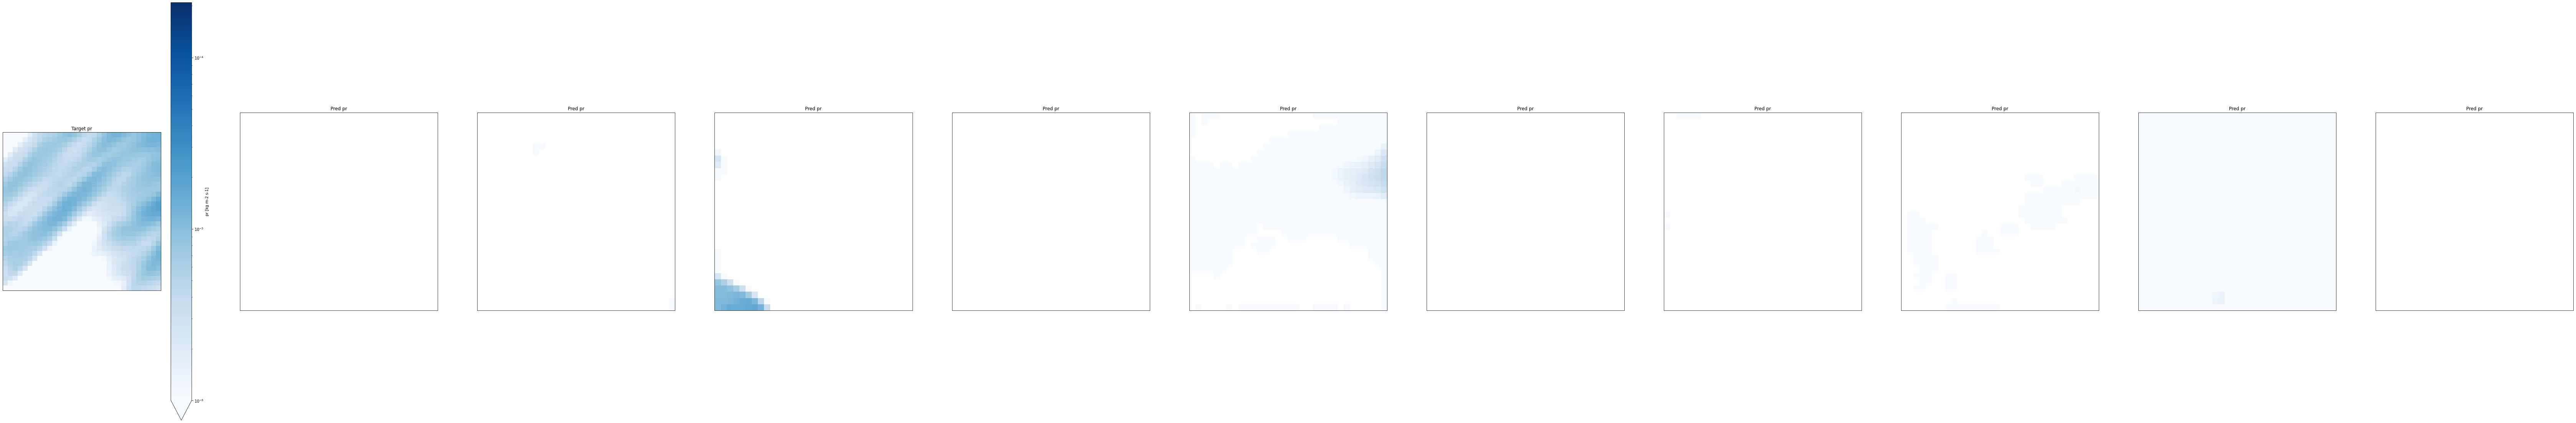

In [51]:
timestamps = np.random.choice(merged_ds["time"], size=10, replace=False)
ds = merged_ds.sel(time=timestamps)
data_arrays = [merged_ds["target_pr"]]+[merged_ds["pred_pr"].sel(sample_id=sample_id) for sample_id in merged_ds["sample_id"]]
vmax = ds["target_pr"].max()

def plot_pr(da, ax, title="", vmin=None, vmax=None, add_colorbar=True, cmap='Blues'):
    da.plot(ax=ax, norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=add_colorbar, cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    
def show_predictions(ds):
    num_predictions = len(ds["sample_id"])
    vmin = min(ds['pred_pr'].min().values, ds['target_pr'].min().values)
    vmin = 1e-6
    vmax = max(ds['pred_pr'].max().values, ds['target_pr'].max().values)
    
    num_plots_per_ts = num_predictions+1 # plot each sample and the coarsened input pr and true target pr
    
    for ts in ds.time:
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(120,20), subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_pr(ds.sel(time=ts)["target_pr"], ax, title="Target pr", vmin=vmin, vmax=vmax)
        
        for sample_id in ds["sample_id"]:
            ax = axes[1+sample_id]
            plot_pr(ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, title="Pred pr", vmin=vmin, vmax=vmax, add_colorbar=False)
            # ds.sel(time=ts, sample_id=sample_id)["pred_pr"].plot(ax=ax, norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=False, cmap='Blues')
            
        
        plt.show()


show_predictions(ds)

## Density

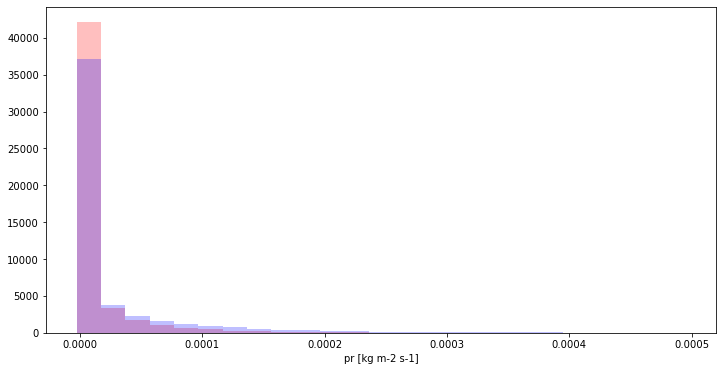

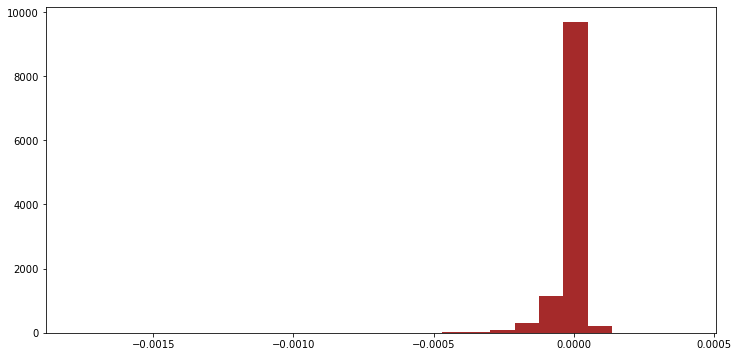

In [109]:
plt.figure(figsize=(12,6))
_, bins, _ = merged_ds['pred_pr'].plot(bins=25, density=True,alpha=0.25, color="red")
merged_ds['target_pr'].plot(bins=bins, density=True,alpha=0.25, color="blue")
plt.show()

plt.figure(figsize=(12,6))
(merged_ds["pred_pr"] - merged_ds['target_pr']).plot(bins=25, density=True, color="brown")
plt.show()

## Scatter

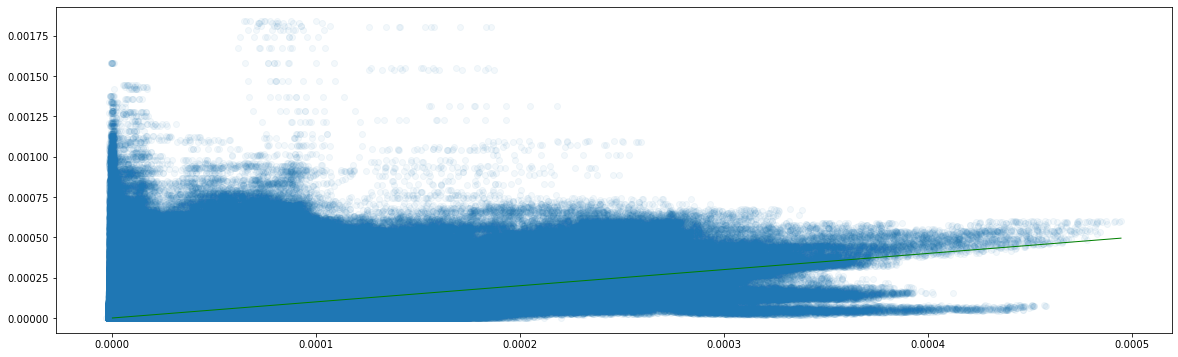

In [115]:
fig, axs = plt.subplots(1, 1, figsize=(20, 6))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


ax = axs

ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
ax.plot([0, tr], [0, tr], linewidth=1, color='green')


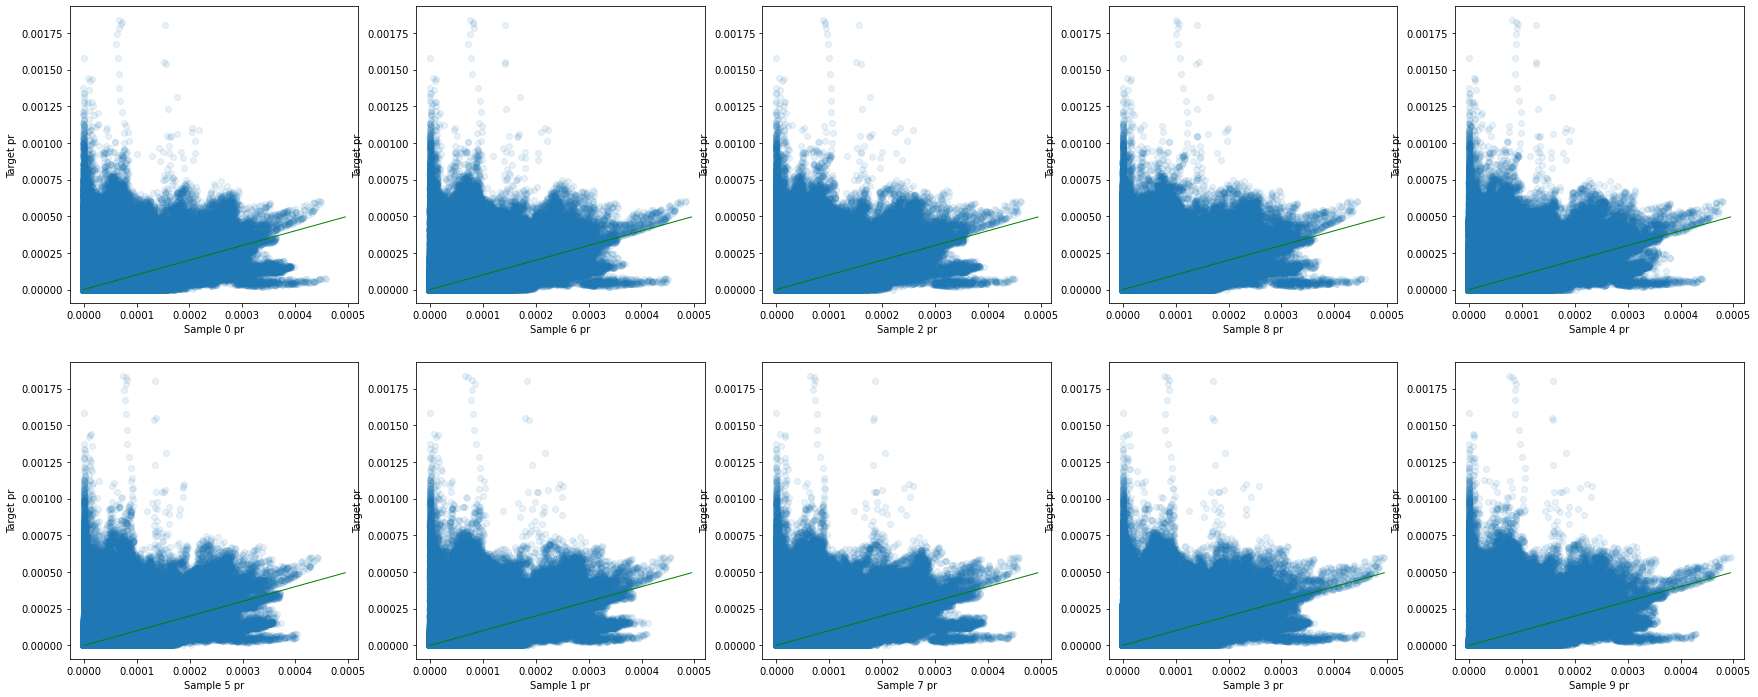

In [114]:
sample_ids = np.arange(10).reshape(2, 5)

fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

for i, sample_id in enumerate(sample_ids.flatten()):
    ax = axs[i%2][i%5]

    ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
    ax.plot([0, tr], [0, tr], linewidth=1, color='green')
    ax.set_xlabel(f"Sample {sample_id} pr")
    ax.set_ylabel(f"Target pr")

## Means

Text(0.5, 1.0, 'Residual mean')

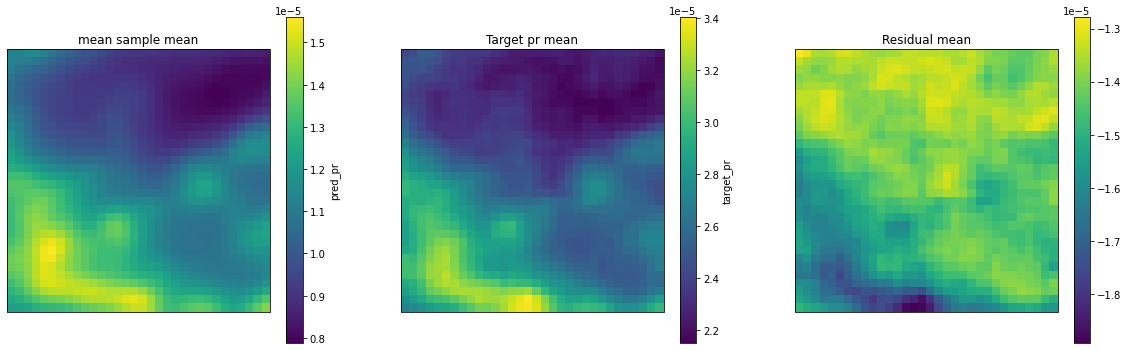

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection=cp_model_rotated_pole))

sample_mean = merged_ds['pred_pr'].mean(dim="sample_id").mean(dim="time")
target_mean = merged_ds['target_pr'].mean(dim="time")

ax = axs[0]
.plot(ax=ax)
ax.set_title("mean sample mean")
ax.coastlines()

ax = axs[1]
target_mean.plot(ax=ax)
ax.set_title("Target pr mean")
ax.coastlines()

ax = axs[2]
(merged_ds['target_pr'] - merged_ds['pred_pr'].mean(dim="sample_id")).mean(dim="time").plot(ax=ax)
ax.set_title("Residual mean")
ax.coastlines()

## Standard deviation

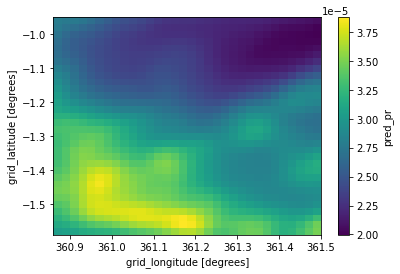

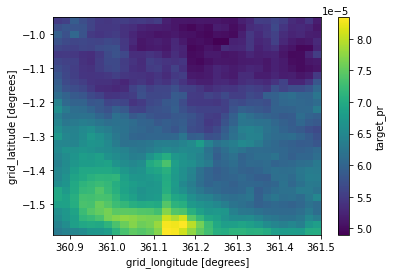

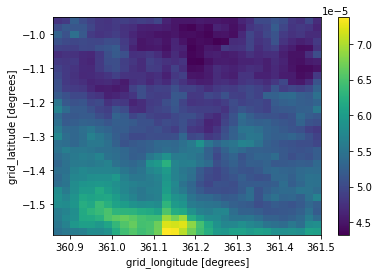

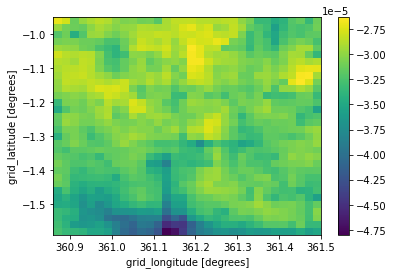

In [113]:
merged_ds['pred_pr'].std(dim="time").mean(dim="sample_id").plot()
plt.show()

merged_ds['target_pr'].std(dim="time").plot()
plt.show()

(merged_ds['pred_pr'].mean(dim="sample_id") - merged_ds['target_pr']).std(dim="time").plot()
plt.show()

(merged_ds['pred_pr'].mean(dim="sample_id") - merged_ds['pred_pr']).std(dim="time").mean(dim="sample_id").plot()
plt.show()

## PSD

In [131]:
import pysteps

Pysteps configuration file found at: /home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pysteps/pystepsrc



In [137]:
pysteps.utils.spectral.rapsd(merged_ds["target_pr"].isel(time=0).values)

array([2.3762689e-10, 2.0079652e-10, 2.0330171e-10, 2.2021780e-10,
       2.3060477e-10, 2.6753849e-10, 2.6953129e-10, 3.2918138e-10,
       2.6452504e-10, 2.1139611e-10, 2.0110921e-10, 1.9626886e-10,
       1.8464520e-10, 1.6606588e-10, 2.3976518e-10, 2.4676119e-10,
       2.8028832e-10], dtype=float32)